# Optimization Tutorial 
This Jupyter notebook goes through the procedure for extracting a cluster, capping the extracted cluster, adding an adosrbate to the cluster, optimizing the cluster, uncapping the cluster and reintegrating the cluster into the starting zeolite. 
****

### Import Required Packages

In [1]:
from maze import Zeolite

In [2]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase import io
import matplotlib.pyplot as plt

****

### Extracting, Adding and Capping Clusters

One of the most useful features of the MAZE package is the ability to add and remove atoms from a ``Zeolite`` object. To demonstrate this, we will extract a cluster from an ``Zeolite`` object, optimize the cluster, and then integrate it back into the main ``Zeolite``.


First, we make a bea_zeolite object with the `Zeolite` class' static `make` method.

/usr/local/anaconda3/envs/zeotype_demos/lib/python3.8/site-packages/ase/io/cif.py:402: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(91, setting=1). This may result in wrong setting!
  warnings.warn(


<AxesSubplot:>

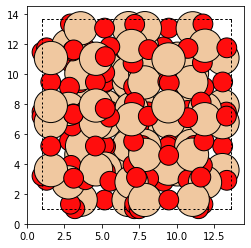

In [3]:
bea_zeolite = Zeolite.make('BEA')
plot_atoms(bea_zeolite)

The next step is to pick a T-site to build the cluster around.

The atom with the index `154` is in the middle of the zeolite, which will make viewing the cluster creation easy. One could also use the ``site_to_atom_indices`` dictionary to select a specific T site.

The Zeolite object uses an internal ``ClusterMaker`` object to select a cluster from the Zeolite. 

By default, a ``DefaultClusterMaker`` object is used. This ``DefaultClusterMaker`` object has a ``get_cluster_indices`` method which uses the ``get_oh_cluster_indices`` function to selects the indices of the central T atom, and surrounding oxygens and hydrogens. There are other cluster functions available in the source code of ``DefaultClusterMaker``. If you need some different functionality, simply make your own ``ClusterMaker`` class and set the ``Zeolite.cluster_maker`` attribute to an instance of your custom cluster maker.

Let's call our ``bea_zeolite``'s ``ClusterMaker`` object's ``get_cluster_indices`` method, to see what indices it will select. 

In [4]:
site = 154 
cluster_indices = bea_zeolite.cluster_maker.get_cluster_indices(bea_zeolite, site)
print(cluster_indices)

[2, 66, 74, 138, 77, 82, 146, 22, 154, 30, 38, 102, 186, 42, 174, 50, 114, 117, 118, 58, 126]


These are the indices of the atoms that will make up the resulting cluster and the indices of the atoms that will be absent in the open defect zeolite. 

We can now make the cluster and open defect zeolites by using the ``get_cluster`` method.

In [5]:
cluster, od = bea_zeolite.get_cluster(154)

The cluster looks like this 

<AxesSubplot:>

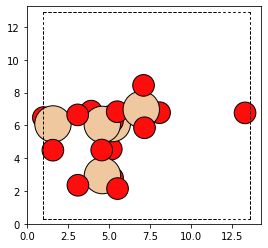

In [6]:
plot_atoms(cluster)

the open defect looks like this 

<AxesSubplot:>

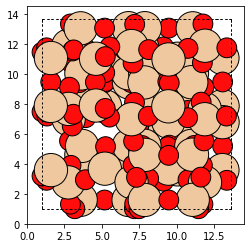

In [7]:
plot_atoms(od)

Both the open defect and the cluster are ``Zeolite`` objects, yet they have a different ztype attribute

In [8]:
display(type(bea_zeolite))
display(type(od))
display(type(cluster))

maze.zeolite.Zeolite

maze.zeolite.Zeolite

maze.zeolite.Zeolite

In [9]:
display(bea_zeolite.ztype)
display(od.ztype)
display(cluster.ztype)

'Zeolite'

'Open Defect'

'Cluster'

Next, we want to cap the cluster and apply changes to some of the internal atoms. Capping involves adding hydrogens and oxygens to the cluster. The built-in ``cap_atoms()`` method returns a new cluster object that has hydrogen caps added to it.

In [10]:
capped_cluster = cluster.cap_atoms()

<AxesSubplot:>

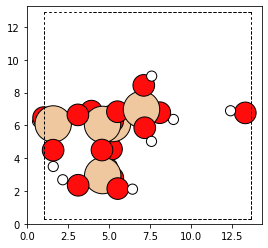

In [11]:
plot_atoms(capped_cluster)

****

### Adding Adsorbates 

Adsorbates are frequently added to Zeolites for adsorption and probing experiments. In this section an adsorbate as added to one of the T-sites in the capped cluster.

We want the adsorbate to be positioned near the central T site. This T site is at `154` in the original index, but the indices are different in the cluster. Thankfully MAZE makes mapping the parent `154` index to the cluster easy with the ``index_mapper.get_index`` function.

The ``index_mapper.get_index`` function takes three arguments the "sender" name, which corresponds to the name of the Zeolite that you know the index of, the "receiver" name, which is the zeolite whose atom you want to know the index of, and the sender index, which is the index that you know. 

For example, to get the capped_cluster central T site index, knowing that the that T site in the parent zeolite had index is 154 we use the following command. 

In [12]:
capped_cluster.index_mapper.get_index(capped_cluster.parent_zeotype.name, capped_cluster.name, 154)

18

This is a little wordy, but it works. We can also use the `site_to_atom_indices` dictionary to see the idenity of all of the sites in the capped cluster. 

In [13]:
capped_cluster.atom_indices_to_sites[18]

'T4'

To add an adsorbate to the cluster, we need an electrophiles atom in place of the Silicon. We make this substitution here using the indices we found in both the parent zeolite and the current zeolite. Substitutions  do not change the index mapper and are not tracked since the indices are not shifted by substitutions. 

In [14]:
capped_cluster.parent_zeotype[154].symbol = 'Sn' # replace original zeolite 154 site Si -> Sn
capped_cluster[18].symbol = 'Sn' # replace site in the capped_cluster

<AxesSubplot:>

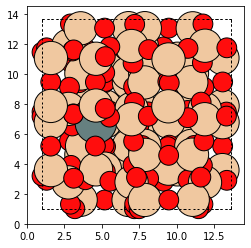

In [15]:
plot_atoms(capped_cluster.parent_zeotype)

<AxesSubplot:>

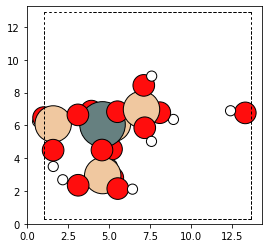

In [16]:
plot_atoms(capped_cluster)

The next stage involves creating an `Adsorbate` object. The `Adsorbate` class inherits from the `ase.Atoms` class, and includes some additional functionality related to the positioning of the `Adsorbate`.

The important parameters are the name and the "host_zeotype". The host zeotype is the zeolite where the adsorbate will be positioned. The adsorbate code works best when the original framework is used as the host zeotype, since it takes into consideration the containment provided by the entire framework. 

In [17]:
from maze.adsorbate import Adsorbate
from ase.build import molecule

<AxesSubplot:>

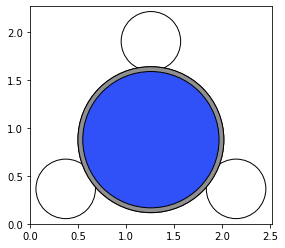

In [18]:
ch3cn = molecule('CH3CN')
ch3cn = Adsorbate(ch3cn, host_zeotype=capped_cluster.parent_zeotype, name='acetonitrile')
plot_atoms(ch3cn)

The Adsorbate class inherits from the ase.Atoms class and thus can be used with ASE's visualization tools

To position the adsorbate, we need to find the index of the nucleophile (i.e. the nitrogen)

In [19]:
for atom in ch3cn:
    print(atom.index, atom.symbol)

0 C
1 C
2 N
3 H
4 H
5 H


The donor atom is the N; thus, we note the index = 2. We could also find this in one step with list comprehension.

In [20]:
nitrogen_index = [atom.index for atom in ch3cn if atom.symbol == 'N'][0]
nitrogen_index

2

In [21]:
#lets position the adsorbate (run this a few times until it works) 
for _ in range(10):
    try:
        ch3cn = ch3cn.position_ads(donor_ind=nitrogen_index, host_ind=154)
        break
    except AssertionError:
        pass

<AxesSubplot:>

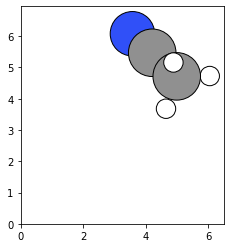

In [22]:
plot_atoms(ch3cn)

Now let's integrate the adsorbate into the cluster. We will use the integrate adsorbate function for this. Notice that the host_zeotype doesn't have to be the capped cluster for the integration to take place. This integrate-adsorbate method also returns a new cluster object and a new adsorbate object. 

In [23]:
cluster_with_ads, ch3cn_in = capped_cluster.integrate_adsorbate(ch3cn)

We can now view the ``cluster_with_ads object``. The positioning will not be perfect, since it relies on some very simple heuristics, but it is a good initial guess for the calculations.

<AxesSubplot:>

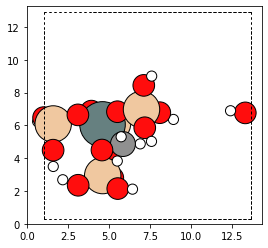

In [24]:
plot_atoms(cluster_with_ads)

### Optimization 

The next stage of this process is optimizing the cluster. Note in the current iteration, we do not optimize the cluster and adsorbate together, but in future work this might take place. 

### Freezing Atom Caps

To perform an optimization, we need to freeze the hydrogen atoms. ASE has built in functions for this purpose, but we need to know the indices of the caps. The indices for all of the atoms and their relationship between each other are stored in the Index Mapper’s main index. In the program, the main index consists of a series of nested dictionaries, but it can easily be visualized by turning it into a Pandas Data Frame. Pandas is not a required package for MAZE so the following line of code is not wrapped in a nice function.

In [25]:
import pandas as pd
from IPython.core.display import HTML

In [26]:
HTML(pd.DataFrame(cluster_with_ads.index_mapper.main_index).to_html())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209
parent,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0,118.0,119.0,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,130.0,131.0,132.0,133.0,134.0,135.0,136.0,137.0,138.0,139.0,140.0,141.0,142.0,143.0,144.0,145.0,146.0,147.0,148.0,149.0,150.0,151.0,152.0,153.0,154.0,155.0,156.0,157.0,158.0,159.0,160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0,182.0,183.0,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeolite_1,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0,118.0,119.0,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,130.0,131.0,132.0,133.0,134.0,135.0,136.0,137.0,138.0,139.0,140.0,141.0,142.0,143.0,144.0,145.0,146.0,147.0,148.0,149.0,150.0,151.0,152.0,153.0,154.0,155.0,156.0,157.0,158.0,159.0,160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0,182.0,183.0,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,13.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open Defect_5,0.0,1.0,NaN,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,NaN,21.0,22.0,23.0,24.0,25.0,26.0,27.0,NaN,28.0,29

If we look at the index mapper, we see different names for different objects and their relationship to each other. The column name is equal to the objects name. The name consists of the type (Zeolite, Adsorbate, Cluster, etc.) followed by an underscore and a unique number. This number is guaranteed to be unique for the course of the program, even across different index mappers.

The ``h_caps_7`` is one such groups of atoms. These are the atoms that we want to freeze in the cluster. Let us visualize the cluster.

In [27]:
h_cap_name = capped_cluster.additions['h_caps'][0]
h_cap_name

'h_caps_6'

<AxesSubplot:>

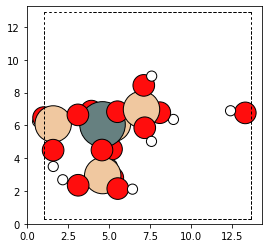

In [28]:
plot_atoms(capped_cluster)

In [29]:
capped_cluster.name 

'Zeolite_7'

The capped cluster has the name `Zeolite_7` . We want to find the indices of all of the hydrogens in the `Zeolite_7` that need to be frozen. This can be tricky if the adsorbate contains hydrogens.

The index mapper object contains an additional function, ``get_index`` which maps between a sender and receiver. If the receiver does not possess any corresponding atoms, then ``None`` is returned. We can use this get_index function to find the hydrogen caps in the ``capped_cluster``.

In [30]:
help(capped_cluster.index_mapper.get_index)

Help on method get_index in module maze.index_mapper:

get_index(sender_name: str, receiver_name: str, sender_index: int) -> int method of maze.index_mapper.IndexMapper instance
    get the index of another object
    :param sender_name: name of the sender zeolite
    :param receiver_name: the name of the receiving zeolite
    :param sender_index: the index of the sender
    :return: the receiving index



In [31]:
cap_indices = []
for atom in capped_cluster:
    h_cap_index = capped_cluster.index_mapper.get_index(sender_name=capped_cluster.name,
                                                        receiver_name=h_cap_name, 
                                                        sender_index=atom.index)
    if h_cap_index is not None:
        cap_indices.append(atom.index)
cap_indices

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Now that we know the indices to fix, we can go ahead and fix them.

In [32]:
from ase.constraints import FixAtoms

In [33]:
c = FixAtoms(indices=cap_indices)
capped_cluster.set_constraint(c)

In [34]:
from IPython.display import Image

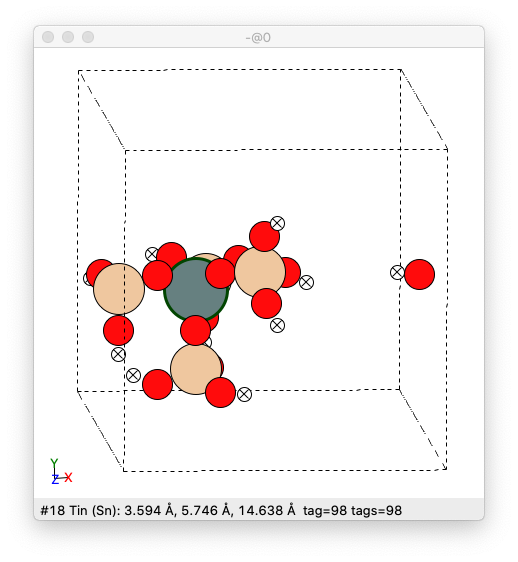

In [35]:
#view(capped_cluster)
Image(filename='output/fixed.png')

You should now notice that the hydrogen atoms have `X`'s on them indicating that they have been fixed/frozen. 

Now let us optimize the cluster! There are two ways to perform this optimization. The first is with an inbuilt calculator. The second is by optimizing the traj file offline, on a remote server. We will show the second one here, as it gives us a chance to showcase the read_write capabilities of the MAZE code. It also provides a record of a computationally expensive step in the calculation, so that in future work we do not need to repeat it. 

The following zeolite folder structure is created. Each zeolite gets its own folder. This is useful as it allows the organization of the pre- and post-optimized zeolites. 

In [36]:
from maze.io_zeolite import save_zeolites

In [37]:
output_dir = "output/zeolites/capped_cluster"
output_zeolite_list = [capped_cluster, capped_cluster.parent_zeotype]
save_zeolites(output_dir, output_zeolite_list, zip=False)

The following zeolite folder structure is created. Each zeolite get's its own folder. This is extremely useful as it allows the organization of the pre and post optimization zeolites.  

In [38]:
!tree 'output/zeolites'

output/zeolites
└── capped_cluster
    ├── Zeolite_10
    │   ├── Zeolite_10.json
    │   └── Zeolite_10.traj
    ├── Zeolite_15
    │   ├── Zeolite_15.json
    │   └── Zeolite_15.traj
    ├── Zeolite_7
    │   ├── Zeolite_7.json
    │   └── Zeolite_7.traj
    ├── index_mapper.json
    └── parent
        ├── parent.json
        └── parent.traj

5 directories, 9 files


Now we optimize the Zeolite using VASP. 

In [39]:
!tree ~/Code/zeotype_demos/optimization_workflow/opt_output

/Users/dda/Code/zeotype_demos/optimization_workflow/opt_output
└── capped_cluster
    ├── Zeolite_11301
    │   ├── 00_opt
    │   │   ├── CHG
    │   │   ├── CHGCAR
    │   │   ├── CONTCAR
    │   │   ├── DOSCAR
    │   │   ├── EIGENVAL
    │   │   ├── IBZKPT
    │   │   ├── INCAR
    │   │   ├── KPOINTS
    │   │   ├── OSZICAR
    │   │   ├── OUTCAR
    │   │   ├── PCDAT
    │   │   ├── POSCAR
    │   │   ├── POTCAR
    │   │   ├── PROCAR
    │   │   ├── REPORT
    │   │   ├── WAVECAR
    │   │   ├── XDATCAR
    │   │   ├── ase-sort.dat
    │   │   ├── op.vasp
    │   │   ├── opt_from_vasp.traj
    │   │   ├── vasp.out
    │   │   └── vasprun.xml
    │   ├── Zeolite_11301.json
    │   ├── Zeolite_11301.traj
    │   ├── job.err
    │   ├── job.out
    │   └── vasp_opt.py
    ├── index_mapper.json
    └── parent
        ├── parent.json
        └── parent.traj

4 directories, 30 files


The optimization is complete and a new `opt_from_vasp.traj` file has been created. VASP (sometimes) sorts the atom indices during optimization. The information is also contained in the vasprun.xml file. 

Reading an optimized function back into memory can be achieved by using the `read_vasp` function. This function takes an optimized structure and matches it to the unoptimized structure.  

In [40]:
from maze.io_zeolite import read_vasp

In [41]:
opt_traj_path = "/Users/dda/Code/zeotype_demos/optimization_workflow/opt_output/capped_cluster/Zeolite_11301/00_opt/opt_from_vasp.traj"

The easiest  way to load in a zeolite after optimization is with the read `read_vasp` function.

In [42]:
help(read_vasp)

Help on function read_vasp in module maze.io_zeolite:

read_vasp(optimized_zeolite_path: str, unoptimized_zeolite: maze.zeolite.Zeolite, atoms_sorted: bool = False)



In [43]:
from ase.io import read

In [44]:
capped_cluster_opt = read_vasp(opt_traj_path, capped_cluster, atoms_sorted=True)

<AxesSubplot:>

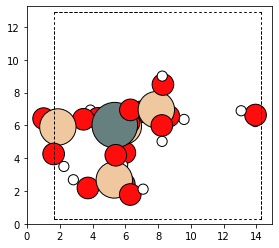

In [45]:
plot_atoms(capped_cluster_opt)

The optimized zeolite has been loaded! It’s caps can now be removed and it can be reintegrated   back into the original zeolite.

The next stage is removing the caps from the atom and reintegrating it back into the original zeolite.

To remove caps, we have to find the name of the caps in ``additions`` dictionary.

In [46]:
dict(capped_cluster_opt.additions)

{'h_caps': ['h_caps_6']}

or we can just select the last h_caps added using pythons list methods

In [47]:
additon_category = 'h_caps'
addition_name = capped_cluster_opt.additions[additon_category][-1]
display(addition_name)

'h_caps_6'

Next we call the remove_addition method

In [48]:
uncapped_cluster = capped_cluster_opt.remove_addition(addition_name, additon_category)

<AxesSubplot:>

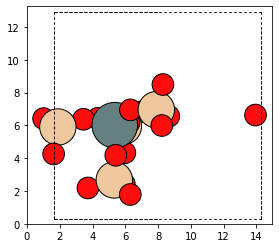

In [49]:
plot_atoms(uncapped_cluster)

The caps have been removed. We can now integrate the cluster back into the original zeolite.

In [50]:
bea_zeolite_with_al = bea_zeolite.integrate(uncapped_cluster)

<AxesSubplot:>

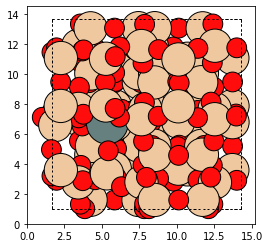

In [51]:
plot_atoms(bea_zeolite_with_al)

The changes have been made. An important thing to notice is that none of the structural manipulation features of MAZE have side-effects. The ``bea_zeolite`` remains unchanged by this integration and a new ``bea_zeolite_with_al`` is created. Along with leading to cleaner code with fewew bugs, this style of programming also allows for method chaining. 

This demo showed the power of the MAZE code to extract and add clusters to zeotypes. This is one of the most useful features in the MAZE code.